# Evaluating a Classifier with FiftyOne

This notebook demonstrates an end-to-end example of fine-tuning a classification model [using fastai](https://github.com/fastai/fastai) on a [Kaggle dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) and using FiftyOne to evaluate it and understand the strengths and weaknesses of both the model and the underlying ground truth annotations.

Specifically, we'll cover:

- Downloading the dataset via the [Kaggle API](https://github.com/Kaggle/kaggle-api)
- Loading the dataset [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- Indexing the dataset by uniqueness using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness) to identify interesting visual characteristics
- Fine-tuning a model on the dataset [using fastai](https://github.com/fastai/fastai)
- [Evaluating](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) the fine-tuned model using FiftyOne
- [Exporting](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) the FiftyOne dataset for offline analysis

**So, what's the takeaway?**

The loss function of your model training loop alone doesn't give you the full picture of a model. In practice, the limiting factor on your model's performance is often data quality issues that FiftyOne can help you address. In this notebook, we'll cover:

- Viewing the *most unique* incorrect samples using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness)
- Viewing the *hardest* incorrect predictions using FiftyOne's [hardness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness)
- Identifying ground truth *mistakes* using FiftyOne's [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes)

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model's performance
- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

## Setup

If you haven't already, install FiftyOne:

In [ ]:
%pip install fiftyone

## Load dataset into FiftyOne

Let's load the dataset into [FiftyOne](https://voxel51.com/docs/fiftyone) and explore it!

In [1]:
import fiftyone as fo

DATASET_DIR = "./datasets/cell_images/"

### Create FiftyOne dataset

FiftyOne provides builtin support for loading datasets in [dozens of common formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) with a single line of code:

In [8]:
# Create FiftyOne dataset
dataset = fo.Dataset.from_dir(
    DATASET_DIR,
    fo.types.ImageClassificationDirectoryTree,
    name="malaria-cell-images",
)
dataset.persistent = True

print(dataset)

 100% |█████████████| 27558/27558 [10.2s elapsed, 0s remaining, 2.7K samples/s]     
Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


### Visualize dataset in the App

Now let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use it to interactively explore the dataset.

For example, try using the [view bar](https://voxel51.com/docs/fiftyone/user_guide/app.html#using-the-view-bar) to sort the samples so that we can view the *most visually unique* samples in the dataset:


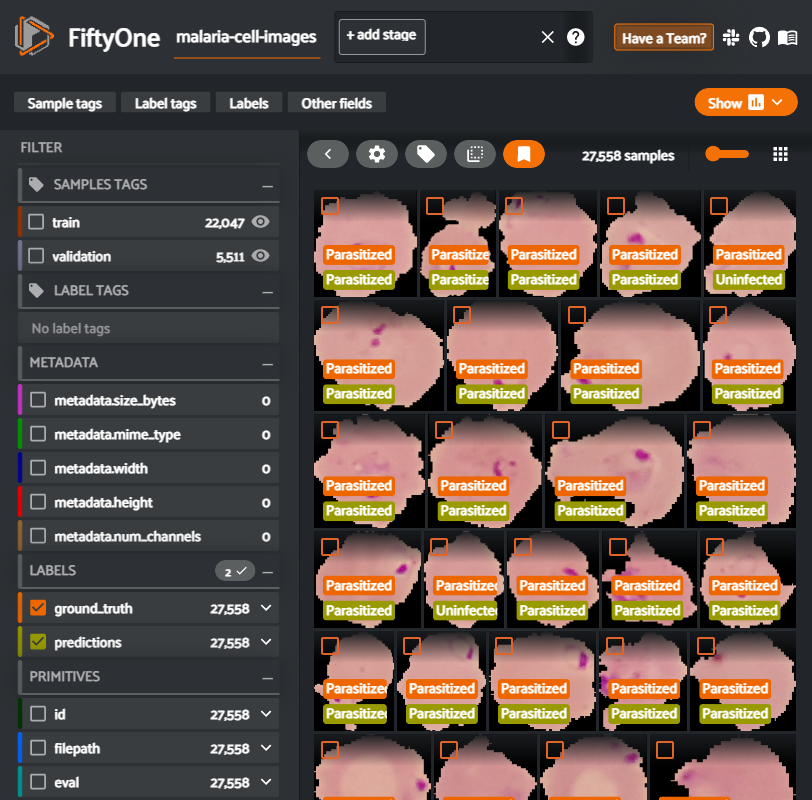

In [42]:
# Most of the MOST UNIQUE samples are parasitized
session = fo.launch_app(dataset)

In [41]:
session

Dataset:     -
Session URL: http://localhost:5151/

## Training a model

Now that we have some basic intuition about the dataset, let's train a model!

In this example, we'll use [fastai](https://github.com/fastai) to fine-tune a pre-trained model on our dataset in just a few lines of code and a few minutes of GPU time.

In [13]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

The code sample below loads the dataset into a fastai data loader:

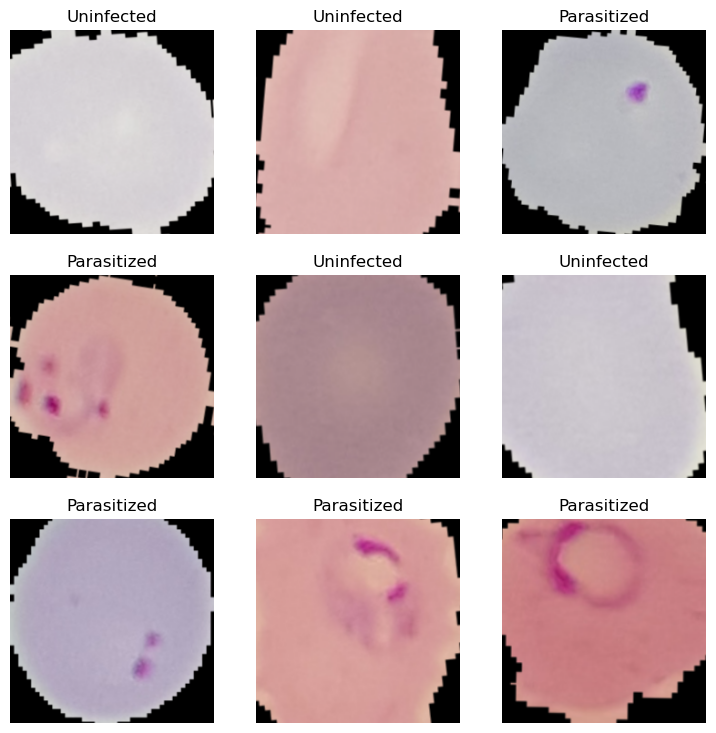

In [22]:
# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]

batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

Now let's load a pre-trained [xresnet34 model](https://docs.fast.ai/vision.models.xresnet.html):

In [26]:
# Load a pre-trained model
learner = vision_learner(data, xresnet34, metrics=[accuracy]).to_fp16()
learner

In [23]:
learner = load_learner("models/xresnet34-malaria.pkl")

and fine-tune it for 15 epochs on our dataset:

In [27]:
# Fine-tune model on our dataset
learner.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.344602,0.252228,0.903284,01:33


epoch,train_loss,valid_loss,accuracy,time
0,0.223568,0.150905,0.946471,01:36
1,0.181157,0.144517,0.947922,01:38


In this case, we reached 96.2% validation accuracy in about 25 minutes!

Let's preview some sample predictions using fastai:

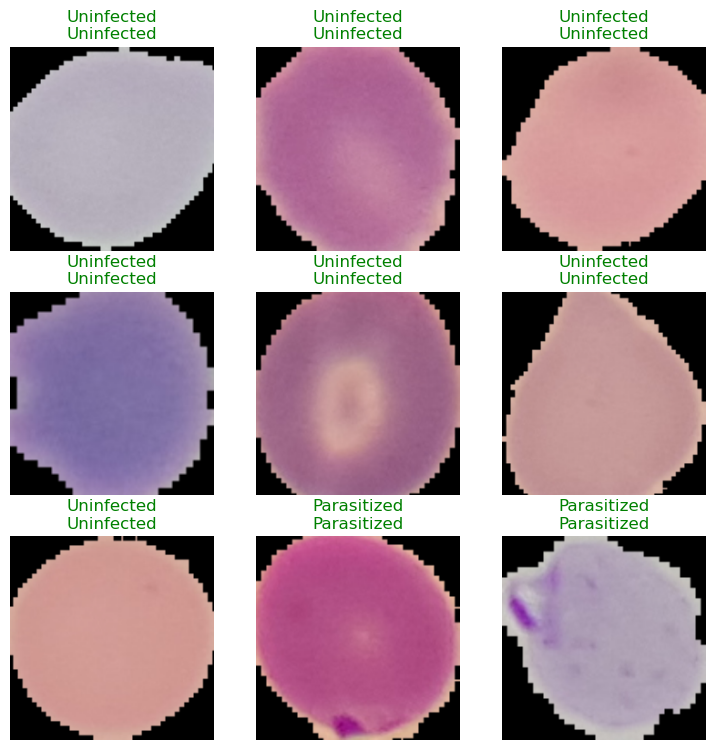

In [21]:
learner.show_results()

### Save model checkpoint

Let's save a checkpoint of our model so we can load it later.

In [28]:
# Save model checkpoint
learner.export("models/xresnet34-malaria-test.pkl")

In [29]:
learner.save("xresnet34-malaria-v3")

Path('models/xresnet34-malaria-v3.pth')

Now we can load the saved model:

In [31]:
# Loads `models/xresnet34-malaria.pth` generated by `.save()` 
learner2 = vision_learner(data, xresnet34, metrics=[accuracy]).to_fp16()
learner2 = learner2.load("xresnet34-malaria-v3")

## Evaluating model with FiftyOne

While 96% accuracy sounds great, aggregate evaluation metrics are not enough to get a full understanding of the performance of a model and what needs to be done to further improve it.

### Add predictions to FiftyOne dataset

Let's [add our model's predictions](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels) to our FiftyOne dataset so we can evaluate it in more detail:

In [24]:
import os 
os.getcwd()

'e:\\Bruno\\HIBA\\Ateneos\\Voxel51'

In [35]:
from fiftyone import ViewField as F

def do_inference(learner, dl, dataset, classes, tag):
    # Perform inference
    preds, _ = learner.get_preds(ds_idx=dl.split_idx)
    preds = preds.numpy()

    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, scores in zip(pb(dl.items), preds):
            sample = dataset[os.path.join(os.getcwd(),str(filepath))]
            target = np.argmax(scores)
            sample.tags = [tag]
            sample["predictions"] = fo.Classification(
                label=classes[target],
                confidence=scores[target],
                logits=np.log(scores),
            )
            sample.save()

classes = list(data.vocab)

# Run inference on train split
do_inference(learner2, data.train, dataset, classes, "train")

# Run inference on validation split
do_inference(learner2, data.valid, dataset, classes, "validation")

 100% |█████████████| 22047/22047 [39.7s elapsed, 0s remaining, 558.9 samples/s]      


 100% |███████████████| 5511/5511 [10.0s elapsed, 0s remaining, 553.3 samples/s]      


In [36]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=["Uninfected", "Parasitized"],
)

In [37]:
results.print_report()

              precision    recall  f1-score   support

  Uninfected       0.93      0.96      0.94     13779
 Parasitized       0.96      0.92      0.94     13779

    accuracy                           0.94     27558
   macro avg       0.94      0.94      0.94     27558
weighted avg       0.94      0.94      0.94     27558



In [32]:
plot = results.plot_confusion_matrix()
plot.show()

PackageError: The requested operation requires that 'ipywidgets<8,>=7.5' is installed on your machine, but found 'ipywidgets==8.0.1'.

If you think this error is inaccurate, you can set `fiftyone.config.requirement_error_level` to 1 (warning) or 2 (ignore).
See https://voxel51.com/docs/fiftyone/user_guide/config.html for details.

In [ ]:
plot.freeze()  # replaces interactive plot with static image

In [33]:
plot = results.plot_pr_curve()
plot.show()

PackageError: The requested operation requires that 'ipywidgets<8,>=7.5' is installed on your machine, but found 'ipywidgets==8.0.1'.

If you think this error is inaccurate, you can set `fiftyone.config.requirement_error_level` to 1 (warning) or 2 (ignore).
See https://voxel51.com/docs/fiftyone/user_guide/config.html for details.

In [ ]:
plot.freeze()  # replaces interactive plot with static image

In [34]:
print(dataset.count_values("eval"))

{'FN': 773, 'TP': 13006, 'FP': 324, 'TN': 13455}


## Appendix B: fastai export

### Export a model

Exporting a fastai model as an encapsulated pickle file is also easy:

In [36]:
# Export your model as a standalone `pkl` file
learner.export("models/xresnet34-malaria.pkl")

In [ ]:
# (Colab only) Download model to your machine
from google.colab import files

files.download("models/xresnet34-malaria.pkl") 

### Loading an exported model

Run the code block below if you'd like to load an existing fastai model and run inference on new data with it in colab:

In [ ]:
# (Colab only) Upload model from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

In [ ]:
%%bash

mkdir -p models/
mv xresnet34-malaria.pkl models/

In [ ]:
# Load exported model
learner = load_learner("models/xresnet34-malaria.pkl")

In [ ]:
# Perform test inference

#IMAGE_PATH = "cell_images/Uninfected/C145P106ThinF_IMG_20151016_154844_cell_62.png"
IMAGE_PATH = "cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"

print(learner.predict(IMAGE_PATH))